In [1]:
#Setting up Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
import math
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# For financial
import yfinance as yf
from yahoofinancials import YahooFinancials
# See more info here: https://github.com/ranaroussi/yfinance and here: https://aroussi.com/post/python-yahoo-finance
import yahoo_fin.stock_info as si
#See more info here: #http://theautomatic.net/yahoo_fin-documentation/


#Necessary not preinstalled packages: 
#pip install yfinance
#pip install yahoofinancials
#pip install Yyahoo_fin

In [2]:
# Fetch Data
df = pd.read_csv("databases/WorldWide-Unicorn-Company-List/World_Wide-Unicorn-Company-List.csv")

In [3]:
# Data Cleaning
df.rename(columns = {'Valuation ($B)':'valuation'}, inplace = True)
df.rename(columns = {'Select Investors':'Investors'}, inplace = True)
df['valuation'] = df['valuation'].str.replace('$', '',regex=True)
df['valuation'][176] = 4.5 # Entry 176 Lenskart contains a non valid value
df['valuation'] = df['valuation'].astype(float)
df['Date Joined'] = pd.to_datetime(df['Date Joined'], format="%d-%m-%Y")
df = pd.concat([df, df['Investors'].str.split(', ', expand=True)], axis=1)
df = df.drop(columns='Investors')

In [4]:
df.columns

Index([    'Company',   'valuation', 'Date Joined',     'Country',
              'City',    'Industry',             0,             1,
                   2,             3],
      dtype='object')

In [5]:
df = df.rename(columns =
               {0: 'Investor1',
                1: 'Investor2',
                2: 'Investor3',
                3: 'Investor4'})

In [6]:
_ = df.groupby(['Industry']).valuation.sum().sort_values(ascending=False)
indexTopIndustries = _.head(30)
print(indexTopIndustries.index)

Index(['Fintech', 'Internet software & services',
       'E-commerce & direct-to-consumer', 'Artificial intelligence', 'Other',
       'Health', 'Supply chain, logistics, & delivery', 'Cybersecurity',
       'Data management & analytics', 'Auto & transportation', 'Hardware',
       'Edtech', 'Mobile & telecommunications', 'Consumer & retail', 'Travel',
       'Artificial Intelligence', 'Consumer & retail ',
       'Artificial intelligence ', 'Cybersecurity ', 'Auto & transportation '],
      dtype='object', name='Industry')


In [7]:
# Delete space and harmonize industry names
df.Industry = df.Industry.replace('Artificial Intelligence', 'Artificial intelligence')
df.Industry = df.Industry.replace('Artificial intelligence ', 'Artificial intelligence')
df.Industry = df.Industry.replace('Consumer & retail ', 'Consumer & retail')

In [8]:
# Get just the top 5 countries
_ = df.groupby(['Country']).valuation.sum().sort_values(ascending=False)
indexTopCountries = _.head(5)
UnicornsTopCountries = df[df['Country'].isin(indexTopCountries.index)]

/home/jose/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/home/jose/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/home/jose/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)


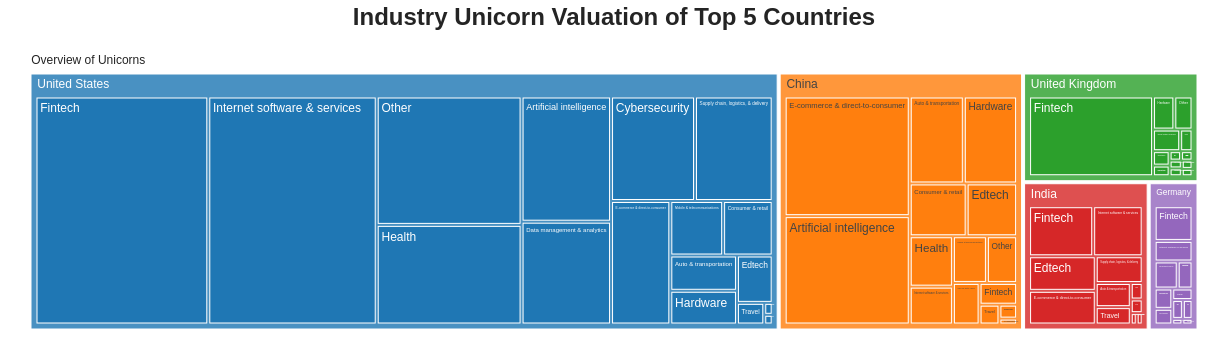

In [9]:
fig = px.treemap(UnicornsTopCountries, path=[px.Constant("Overview of Unicorns"), 'Country', 'Industry'], values='valuation')
fig.update_layout(title='<b>Industry Unicorn Valuation of Top 5 Countries<b>', titlefont={'size': 24}, title_x=0.5, template='simple_white')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

/home/jose/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/jose/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/jose/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



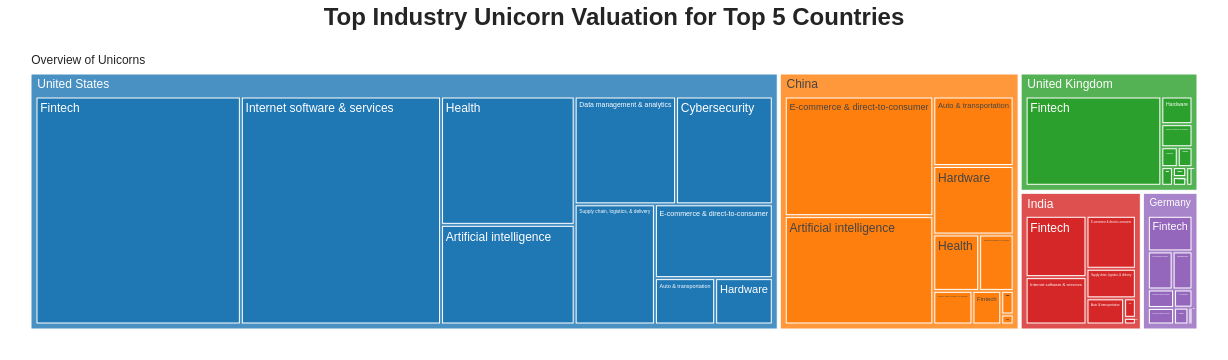

In [10]:
# Top industries for top countries
# Filter out 'Other' as give us not much information
UnicornsTopCountries = UnicornsTopCountries[~UnicornsTopCountries['Industry'].isin(['Other'])]
_ = UnicornsTopCountries.groupby(['Industry']).valuation.sum().sort_values(ascending=False)
indexTopIndustries = _.head(10)
UniTopCountriesIndustries = UnicornsTopCountries[UnicornsTopCountries['Industry'].isin(indexTopIndustries.index)]
fig = px.treemap(UniTopCountriesIndustries, path=[px.Constant("Overview of Unicorns"), 'Country', 'Industry'], values='valuation')
fig.update_layout(title='<b>Top Industry Unicorn Valuation for Top 5 Countries<b>', titlefont={'size': 24}, title_x=0.5, template='simple_white')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [11]:
nasdaq_list = si.tickers_nasdaq(include_company_data = True)
nasdaq_list.columns

Index(['Symbol', 'Security Name', 'Market Category', 'Test Issue',
       'Financial Status', 'Round Lot Size', 'ETF', 'NextShares'],
      dtype='object')

In [12]:
# Reset index 
UniTopCountriesIndustries = UniTopCountriesIndustries.reset_index(drop=True)
UniTopCountriesIndustries['Symbol'] = pd.Series(dtype='object')
# Get intersting companies -> Unicorns which are listed on nasdaq
index = 0
for Name in enumerate(UniTopCountriesIndustries['Company']):
    symb = nasdaq_list['Symbol'][nasdaq_list['Security Name'].str.match(Name[1], case=False) == True]
#dfmi.loc[:, ('one', 'second')] This is preferred over ... because of operational time, besides this passes a nested tuple of 
# (slice(None),('one','second')) to a single call to __getitem__. 
#This allows pandas to deal with this as a single entity. Furthermore this order of operations can be significantly faster, 
# and allows one to index both axes if so desired.
# Try using .loc[row_indexer,col_indexer] = value instead
#--> See more details here: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    if not symb.empty:
        UniTopCountriesIndustries.loc[index, 'Symbol'] = symb.array[0]
        #Take a look if it makes sense :/
    index+=1

In [13]:
#Lets take just the companies located in US
#UniTopIndustriesUS = UniTopCountriesIndustries[df['Country'].str.fullmatch('United States', case=False) == True]
UniTopCountriesIndustries['Year Joined'] = pd.Series(dtype='float64')
UniTopCountriesIndustries['Year Joined'] = pd.DatetimeIndex(UniTopCountriesIndustries['Date Joined']).year
UniTopIndustriesUS = UniTopCountriesIndustries[UniTopCountriesIndustries['Country'] == 'United States']

In [14]:
#Lets take the unicorns with symbol different to NaN -> This means teh company can be found in nasdaq
UniTopIndUSNasdaq = UniTopIndustriesUS.dropna(subset=['Symbol'])
UniTopIndUSNasdaq = UniTopIndUSNasdaq.reset_index(drop=True)
UniTopIndUSNasdaq = UniTopIndUSNasdaq.drop(columns='Investor4')

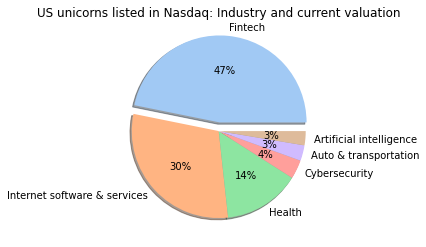

In [15]:
# Graph of Top US unicorns listed in Nasdaq: Industry and current valuation
palette_color = sns.color_palette('pastel')
test = UniTopIndUSNasdaq.groupby('Industry').valuation.sum().sort_values(ascending=False)
plt.pie(test, labels = test.index, autopct='%.0f%%', colors=palette_color, shadow=True,  explode = (0.1, 0, 0, 0, 0, 0))
plt.title('US unicorns listed in Nasdaq: Industry and current valuation')
plt.show()

Text(0.5, 1.0, 'Unicorns in Nasdaq: Industry and current valuation')

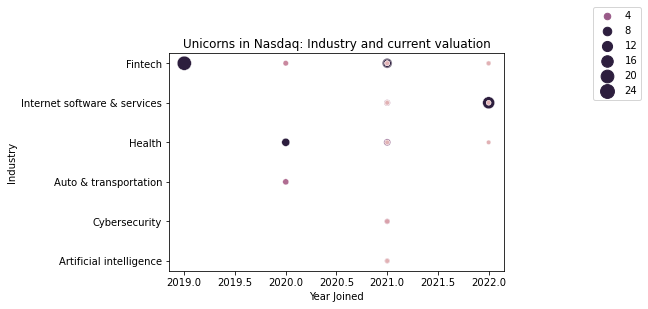

In [16]:
# Graph of Top unicorns within the top 5 countries: Industry and current valuation
g = sns.scatterplot(data=UniTopIndUSNasdaq, x="Year Joined", y="Industry", hue="valuation", size="valuation", sizes=(20, 200), hue_norm=(0, 7), legend="brief")
g.legend(loc='center left', bbox_to_anchor=(1.25, 1), ncol=1)
g.set_title('Unicorns in Nasdaq: Industry and current valuation')

Text(0.5, 1.0, 'US unicorns listed in Nasdaq: Company and Date joined showing their current valuation')

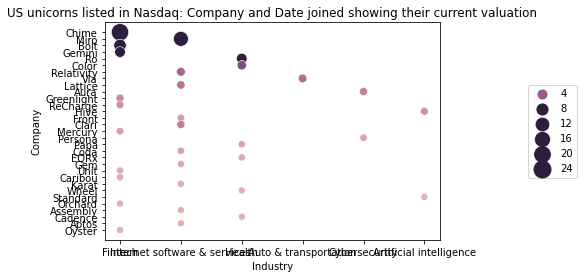

In [17]:
# Graph of Top US unicorns listed in Nasdaq: Company and Date joined showing their current valuation
#sns.set(rc = {'figure.figsize':(11,6)})
#sns.set_style("whitegrid")
g = sns.scatterplot(data=UniTopIndUSNasdaq, x="Industry", y="Company", hue="valuation", size="valuation", sizes=(50, 300), hue_norm=(0, 7), legend="brief")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
g.set_title('US unicorns listed in Nasdaq: Company and Date joined showing their current valuation')
#import seaborn as sns1

Text(0.5, 1.0, 'Unicorns within the top 5 countries: Industry and current valuation')

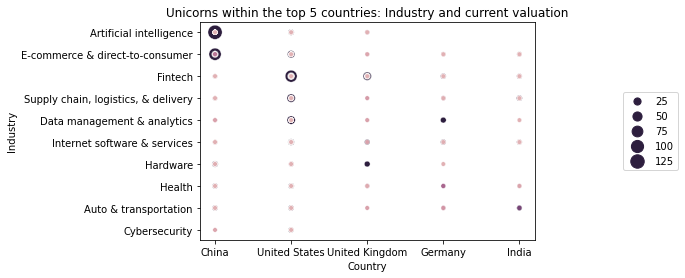

In [18]:
# Graph of Top unicorns within the top 5 countries: Industry and current valuation
#sns.set(context='notebook’, style=’darkgrid’, palette=’deep’, font=’sans-serif’, font_scale=1, color_codes=True, rc=None)
#sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
g = sns.scatterplot(data=UniTopCountriesIndustries, x="Country", y="Industry", hue="valuation", size="valuation", sizes=(20, 200), hue_norm=(0, 7), legend="brief")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
g.set_title('Unicorns within the top 5 countries: Industry and current valuation')

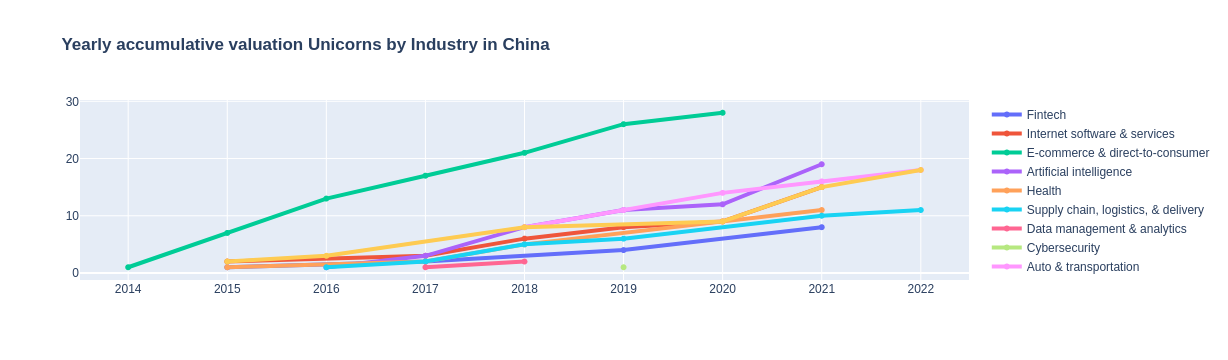

In [19]:
industries = UniTopCountriesIndustries.groupby(['Industry']).valuation.sum().sort_values(ascending=False).index
# cumSum in China
#China = UniTopCountriesIndustries[UniTopCountriesIndustries['Country'] == 'China'].groupby('Year Joined')['valuation'].count().cumsum().reset_index()
China = UniTopCountriesIndustries[UniTopCountriesIndustries['Country'] == 'China']
_ = [ China[China['Industry'] == i].groupby('Year Joined')['valuation'].count().cumsum().reset_index() for i in industries]
fig = go.Figure()
x = 0
for i in industries:
        fig.add_trace(go.Scatter(x = _[x]['Year Joined'],
                                 y = _[x]['valuation'],
                                 line = dict(width=4,
                                             dash='solid'),
                                 name = i))
        x+=1
fig.update_layout(title='<b>Yearly accumulative valuation Unicorns by Industry in China<b>', title_xanchor='left', showlegend=True)
fig.show()

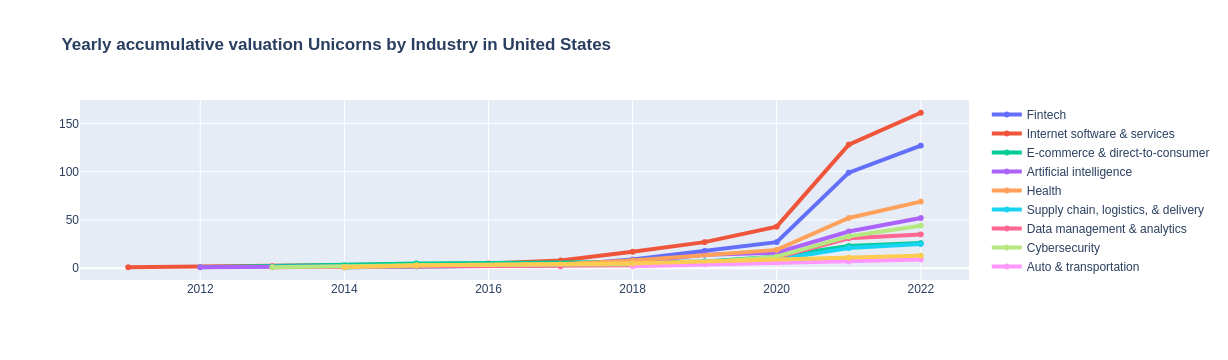

In [20]:
# cumSum in US
US = UniTopCountriesIndustries[UniTopCountriesIndustries['Country'] == 'United States']
_ = [ US[US['Industry'] == i].groupby('Year Joined')['valuation'].count().cumsum().reset_index() for i in industries]
fig = go.Figure()
x = 0
for i in industries:
        fig.add_trace(go.Scatter(x = _[x]['Year Joined'],
                                 y = _[x]['valuation'],
                                 line = dict(width=4,
                                             dash='solid'),
                                 name = i))
        x+=1
fig.update_layout(title='<b>Yearly accumulative valuation Unicorns by Industry in United States<b>', title_xanchor='left', showlegend=True)
fig.show()

In [21]:
print('Number of Unicorns:', UniTopCountriesIndustries.shape[0])

print('Number of Unicorns from USA:', UniTopIndustriesUS.shape[0])

print('Number of Unicorns from USA listed in NASDAQ:', UniTopIndUSNasdaq.shape[0])

Number of Unicorns: 811
Number of Unicorns from USA: 561
Number of Unicorns from USA listed in NASDAQ: 31


In [ ]:
# Select two companies of the top company of unrepresented industries which have some potential to grow
# 'Artificial intelligence' and 'Internet software & services'

In [22]:
UniTopIndUSNasdaq[UniTopIndUSNasdaq.Industry == 'Artificial intelligence']

Company  valuation Date Joined        Country           City  \
12      Hive        2.0  2021-04-21  United States  San Francisco   
25  Standard        1.0  2021-02-17  United States  San Francisco   

                   Industry            Investor1       Investor2  \
12  Artificial intelligence  Tomales Bay Capital  Bain & Company   
25  Artificial intelligence                  CRV    Y Combinator   

              Investor3 Symbol  Year Joined  
12     General Catalyst   HIVE         2021  
25  Initialized Capital    LAB         2021

In [25]:
UniTopIndUSNasdaq[UniTopIndUSNasdaq.Industry == 'Internet software & services']

Company  valuation Date Joined        Country           City  \
1         Miro       17.5  2022-01-05  United States  San Francisco   
6   Relativity        3.6  2021-03-18  United States        Chicago   
8      Lattice        3.0  2021-03-23  United States  San Francisco   
13       Front        1.7  2022-06-28  United States  San Francisco   
14       Clari        2.6  2021-03-03  United States      Sunnyvale   
18        Coda        1.4  2021-07-08  United States  Mountain View   
20         Gem        1.2  2021-09-28  United States  San Francisco   
23       Karat        1.1  2021-10-13  United States        Seattle   
27    Assembly        1.0  2021-09-21  United States    Culver City   
29       Aptos        1.0  2022-03-15  United States      Palo Alto   

                        Industry             Investor1  \
1   Internet software & services                 Accel   
6   Internet software & services           Silver Lake   
8   Internet software & services       Khosla Ventures   
13  Internet software & services       Sequoia Capital   
14  Internet software & services       Sequoia Capital   
18  Internet software & services     Greylock Partners   
20  Internet software & services                 Accel   
23  Internet software & services                   8VC   
27  Internet software & services  Advent International   
29  Internet software & services   Andreessen Horowitz   

                   Investor2                      Investor3 Symbol  \
1             AltaIR Capital  Technology Crossover Ventures   MIRO   
6             ICONIQ Capital                           None   RACY   
8             Thrive Capital                   Y Combinator   LSCC   
13            Uncork Capital            Salesforce Ventures   FICV   
14     Bain Capital Ventures                  enaya Capital   CLRM   
18          General Catalyst                Khosla Ventures   CODA   
20         Greylock Partners      Meritech Capital Partners   GMTX   
23  Norwest Venture Partners        Tiger Global Management    KRT   
27                       PSG     Providence Equity Partners   ASMB   
29         Coinbase Ventures        Tiger Global Management   APTO   

    Year Joined  
1          2022  
6          2021  
8          2021  
13         2022  
14         2021  
18         2021  
20         2021  
23         2021  
27         2021  
29         2022

[*********************100%***********************]  1 of 1 completed


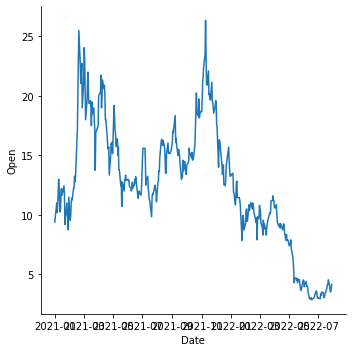

In [43]:
hive_hist = yf.download('HIVE','2021-01-01','2022-08-01')
sns.relplot(x="Date", y="Open", kind="line", data=hive_hist1)

[*********************100%***********************]  1 of 1 completed


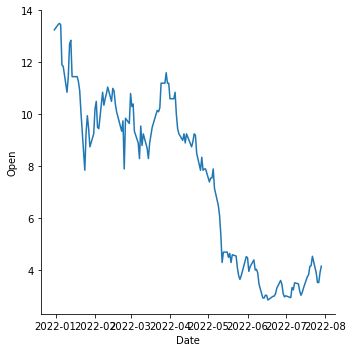

In [40]:
# Unfortunately Hive pays no dividens :( 
#Lets take a look at the stocks history
miro_hist = yf.download('HIVE','2022-01-01','2022-08-01')
sns.relplot(x="Date", y="Open", kind="line", data=miro_hist)

[*********************100%***********************]  1 of 1 completed


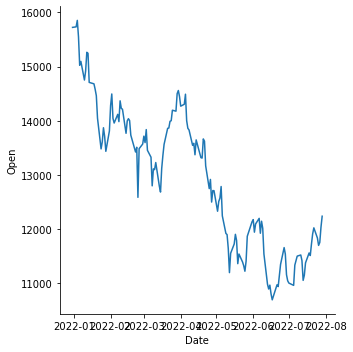

In [42]:
# Lets take a look at the NASDAQ index
nasdaq_hist = yf.download('^IXIC','2022-01-01','2022-08-01')
sns.relplot(x="Date", y="Open", kind="line", data=nasdaq_hist)